In [2]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from shapely.ops import cascaded_union

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_input     = '/Users/Guille/Desktop/india_power/input_data_2022/'
path_to_data      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data/'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data_2022/load'

In [3]:
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

In [355]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_trasfers(scen_labels_):

    def __load_tx_losses_from_csv(df_, scenario):
        
        # df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        # df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']
        df_['transmission_flow_mw']        = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

#         df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
#         df_1_['technology'] = 'Tx_Losses'
#         df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
#                                                       'load_zone_to': 'load_zone'})

#         df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
#         df_2_['technology'] = 'Tx_Losses'
#         df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
#                                                       'load_zone_from': 'load_zone'})
        
        df_3_ = df_[['period', 'load_zone_to', 'transmission_flow_mw']].copy()
        df_3_ = df_3_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_to': 'load_zone'})

        df_3_.loc[df_3_['power_mw'] >= 0., 'technology'] = 'Import'
        df_3_.loc[df_3_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_4_ = df_[['period', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_4_ = df_4_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_from': 'load_zone'})

        df_4_['power_mw'] = - df_4_['power_mw']

        df_4_.loc[df_4_['power_mw'] >= 0., 'technology'] = 'Import'
        df_4_.loc[df_4_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_ = pd.concat([df_3_, df_4_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)



In [352]:
def _plot_total_tranmission_exchange(ax, df_, scen_labels_, 
                                     legend_title = 'Scenarios',
                                     ylabel       = 'Electricity Transmission (TWh)',
                                     units        = 1e6, 
                                     legend       = True):

    df_ = df_.groupby(['period', 
                       'scenario',
                       'technology']).agg({'power_mw': 'sum'}).reset_index(drop = False)

    scens_   = scen_labels_['scenario']
    periods_ = df_['period'].unique()

    # techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    # colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()
    
    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_ = []

    for scen, i_scen in zip(scens_, range(len(scens_))):
        color = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0]
        label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        for period, i_period in zip(periods_, range(len(periods_))):
            
            idx_ = (df_['scenario'] == scen) & (df_['period'] == period)
            
            y = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Import'), 'power_mw']).to_numpy()[0]
            z = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Export'), 'power_mw']).to_numpy()[0]            
            
            if i_period == 0:
                ax.bar(x_[i_period], (y + z)/units, width, label = label, 
                                                           color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            else:
                ax.bar(x_[i_period], (y + z)/units, width, color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            
            ticks_.append(x_[i_period])

        x_ = x_ + .9/len(scens_)

    ticks_ = np.mean(np.array(ticks_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.set_xticks(ticks_, periods_)
    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc            = 'upper left',
                  title          = legend_title,
                  title_fontsize = 14,
                  fontsize       = 10,
                  #bbox_to_anchor = (1, 0.75),
                  frameon        = False)

    ax.set_ylim(-50.,)
    ax.set_xlim(ticks_[0] - .5, ticks_[-1] + .5)

    # ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_transmission_exchange_by_zone(ax, df_, scen_labels_, scen, period,
                                        title    = '',
                                        ylabel   = '',
                                        xlabel   = 'Electricity Transmission (TWh)',
                                        units    = 1e6, 
                                        legend   = True, 
                                        N_states = 30):


    zones_   = df_['load_zone'].unique()
    
    width = 0.8

    ax.barh(0., 0., label  = 'Import',
                    align  = 'center',
                    color  = '#900C3F',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Export',
                    color  = '#2cb4b4',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Total',
                    align  = 'center',
                    color  = '#92918b',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Net',
                    color  = '#136564',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    x_    = np.linspace(0, N_states - 1, N_states)
             
    df_pp_ = df_.loc[(df_['scenario'] == scen) & (df_['period'] == period) & (df_['technology'] == 'Import')].reset_index(drop = True)
    
    y_ = pd.DataFrame(columns = ['Import'], index = zones_)
    y_['Import'] = 0.
    
    y_.loc[df_pp_['load_zone'].values, 'Import'] = df_pp_['power_mw'].to_numpy()

    df_pp_ = df_.loc[(df_['scenario'] == scen) & (df_['period'] == period) & (df_['technology'] == 'Export')].reset_index(drop = True)

    z_ = pd.DataFrame(columns = ['Export'], index = zones_)
    z_['Export'] = 0.

    z_.loc[df_pp_['load_zone'].values, 'Export'] = df_pp_['power_mw'].to_numpy()

    w_ = np.absolute(y_['Import']) + np.absolute(z_['Export'])
    v_ = np.absolute(y_['Import']) - np.absolute(z_['Export'])
    idx_ = np.argsort(w_)[-N_states:]
    
    im_ = ax.barh(x_, y_['Import'].to_numpy()[idx_]/units,  
                  align  = 'center',
                  color  = '#900C3F',
                  height = width, 
                  zorder = 10)
    
    ex_ = ax.barh(x_, z_['Export'].to_numpy()[idx_]/units,
                  color  = '#2cb4b4',
                  align  = 'center',
                  height = width, 
                  zorder = 10)
    
    ax.bar_label(container  = ex_, 
                 labels     = [zone.replace("_", " ") for zone in zones_[idx_]], 
                 label_type = "edge", 
                 padding    = 5, 
                 fontsize   = 10)

    ttl_ = ax.barh(x_, w_[idx_]/units,
                  color  = '#92918b',
                  align  = 'center',
                  height = width/2., 
                  zorder = 10)
    
    net_ = ax.barh(x_, v_[idx_]/units,
                   color  = '#136564',
                   align  = 'center',
                   height = width/2., 
                   zorder = 10)
        
    ax.set_yticks([], [])
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14, labelpad = 30.)
    
    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.axvline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    if legend:
        ax.legend(loc      = 'lower right',
                  fontsize = 14,
                  frameon  = False)

    ax.set_xlim(-600., 600)
    ax.set_ylim(-1, len(zones_))

    ax.set_title(title, fontsize = 16)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'x')

In [353]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_net_transfers(scen_labels_):

    def __load_net_tx_from_csv(df_, scenario):
        
        df_['transmission_flow_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

        
        df_p_ = df_[['transmission_line', 'period', 'load_zone_to', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_p_['transmission_line'] = df_p_['transmission_line'].str.replace('_new', '')

        df_p_ = df_p_.groupby(['transmission_line', 
                               'period', 
                               'load_zone_to', 
                               'load_zone_from']).agg({'transmission_flow_mw': 'sum'}).reset_index(drop = False)

        df_p_['scenario'] = scenario
        
        return df_p_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_net_tx_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)



In [ ]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_transmission_capacity(scen_labels_):

    def __load_net_tx_from_csv(df_, scenario):
        
        df_['transmission_flow_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

        
        df_p_ = df_[['transmission_line', 'period', 'load_zone_to', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_p_['transmission_line'] = df_p_['transmission_line'].str.replace('_new', '')

        df_p_ = df_p_.groupby(['transmission_line', 
                               'period', 
                               'load_zone_to', 
                               'load_zone_from']).agg({'transmission_flow_mw': 'sum'}).reset_index(drop = False)

        df_p_['scenario'] = scenario
        
        return df_p_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_net_tx_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

tech_cost_ = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 

transmission_ = _load_transfer_capacity(tech_cost_)

In [315]:
def _opt_dist(x_, y_, d = 1.35, delta = 0.1):
    
    def __update_position(x, x_0, z):
        return x + ((x - x_0)/z)*delta, x_0 + ((x_0 - x)/z)*delta  
    
    while True:
        flag = True
        for i in range(x_.shape[0]):
            for j in range(x_.shape[0]):
                if i != j:
                    z = np.sqrt( (x_[j] - x_[i])**2 + (y_[j] - y_[i])**2 )
                    if z < d:
                        x_[j], x_[i] = __update_position(x_[j], x_[i], z)
                        y_[j], y_[i] = __update_position(y_[j], y_[i], z)
                        flag = False
        if flag:
            break

    return x_, y_

_map = gpd.read_file(path_to_data + r"map/india-polygon.shp").to_crs("epsg:4326")
#_map = _map.drop([0, 15])

_nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _map.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _map.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _map.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _map.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})
city_ = city_.drop([28, 34, 35]).reset_index(drop = True)

load_zones_ = pd.read_csv(path_to_input + r"/india_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])

load_zones_ = load_zones_.drop([3, 35, 36]).reset_index(drop = True)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')
load_zones_p_ = load_zones_.copy()

load_zones_p_['longitude'], load_zones_p_['latitude'] = _opt_dist(load_zones_p_['longitude'].to_numpy(), 
                                                                  load_zones_p_['latitude'].to_numpy())
               
load_zones_p_.loc[30, 'longitude'] += .7
load_zones_p_.loc[29, 'longitude'] -= .3

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_48235/2671022349.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


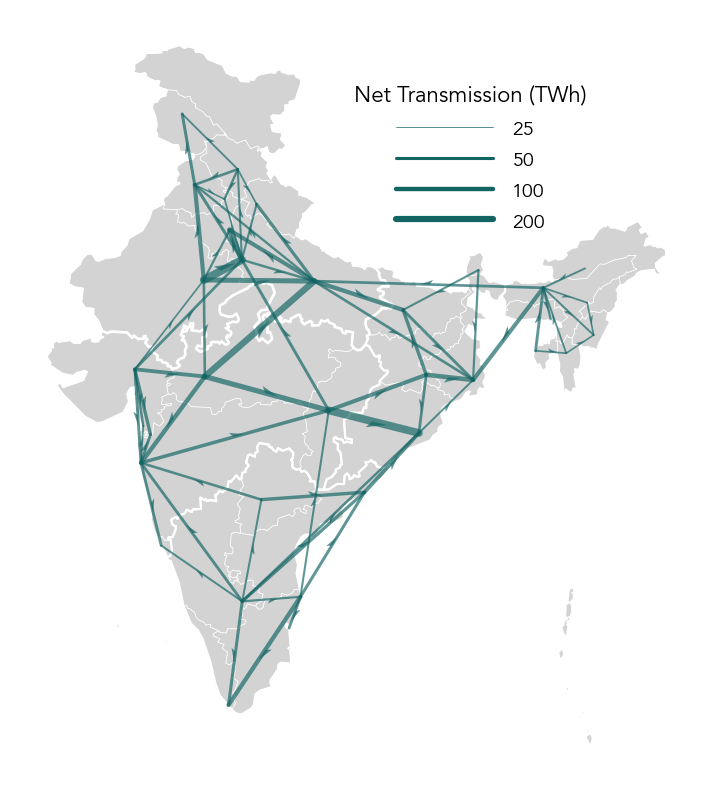

In [328]:
def _plot_transmission_exchange(ax, df_, load_zones_, period, sceneario):
    
    def __f(x):
        return np.sqrt(np.absolute(x)/1e7)

    df_p_ = df_.loc[(df_['scenario'] == sceneario) & (df_['period'] == period)].reset_index(drop = True)

    for i in range(net_exchange_p_.shape[0]):
        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == df_p_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == df_p_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)

        exchange = df_p_.loc[i, 'transmission_flow_mw']

        z = __f(exchange)
        w = np.sign(exchange)

        line = ax.plot(y_, x_, 
                       lw             = 1 + z, 
                       zorder         = 10, 
                       color          = '#136564', 
                       solid_capstyle = 'round', 
                       alpha          = .675)

        l = .2 + np.sqrt(z)/5

        dy = (y_[1] - y_[0])/2.
        dx = (x_[1] - x_[0])/2.
        ds = np.sqrt(dy**2 + dx**2)
        lx = dx/ds
        ly = dy/ds
        if w > 0:
            ax.arrow(y_[0] + dy, x_[0] + dx, ly*l, lx*l, 
                     overhang   = 0.25, 
                     shape      = 'left', 
                     color      = '#136564',
                     ls         = 'None', 
                     head_width = l, 
                     zorder     = 11, 
                     alpha      = .675,
                     length_includes_head = True)
        else:
            ax.arrow(y_[0] + dy, x_[0] + dx, -ly*l, -lx*l, 
                     overhang   = 0.25, 
                     shape      = 'right', 
                     color      = '#136564',
                     ls         = 'None', 
                     head_width = l, 
                     zorder     = 11, 
                     alpha      = .675,
                     length_includes_head = True)

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')
    
    # #95cca3 #2cb7b5
    line1 = Line2D([], [], color = '#136564', lw = __f(2500000), solid_capstyle ='round')
    line2 = Line2D([], [], color = '#136564', lw = __f(50000000), solid_capstyle ='round')
    line3 = Line2D([], [], color = '#136564', lw = __f(100000000), solid_capstyle ='round')
    line4 = Line2D([], [], color = '#136564', lw = __f(200000000), solid_capstyle ='round')

    ax.legend((line1, line2, line3, line4), ('25', '50', '100', '200'), 
               title_fontsize = 16,
               title          = 'Net Transfers (TWh)',
               handlelength   = 5.,
               handletextpad  = 1.,
               labelspacing   = .5,
               frameon        = False, 
               bbox_to_anchor = (0.475, 0.925), 
               prop           = {'size': 14})

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_xticks([], [])
    ax.set_yticks([], [])


period = 2050
scen   = tech_cost_.loc[tech_cost_['label'].str.contains('Ref'), 'scenario'].to_numpy()[0]

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

_plot_transmission_exchange(ax, net_exchange_, load_zones_p_, period, scen)

plt.savefig(path_to_images + '/transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Transmission Exchange

In [254]:
tech_cost_ = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 

transmission_ = _load_transmission(tech_cost_)
net_exchange_ = _load_net_exchange(tech_cost_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

### System Level

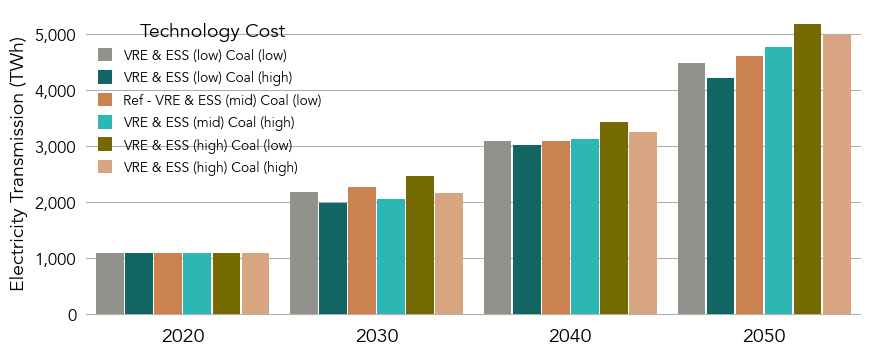

In [195]:
fig = plt.figure(figsize = (10, 4))
_ax = plt.subplot(111)

_plot_total_tranmission_exchange(_ax, transmission_, tech_cost_, legend_title = 'Technology Cost')

plt.savefig(path_to_images + r'/system_level-tranmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

### Zone Level

In [294]:
print(transmission_.loc[transmission_['load_zone'].str.contains('Raja') & (transmission_['period'] == 2050)])

      period technology  load_zone      power_mw  \
221     2050     Export  Rajasthan -3.848769e+08   
255     2050     Import  Rajasthan  4.290753e+07   
484     2050     Export  Rajasthan -3.828106e+08   
518     2050     Import  Rajasthan  3.402087e+07   
747     2050     Export  Rajasthan -3.735350e+08   
781     2050     Import  Rajasthan  3.316912e+07   
1010    2050     Export  Rajasthan -3.802091e+08   
1044    2050     Import  Rajasthan  4.038399e+07   
1273    2050     Export  Rajasthan -3.606184e+08   
1307    2050     Import  Rajasthan  4.250621e+07   
1536    2050     Export  Rajasthan -3.578094e+08   
1570    2050     Import  Rajasthan  4.034322e+07   

                                               scenario  
221   VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  
255   VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  
484   VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...  
518   VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...  
747   VREmid_STmid_CONVmid_H2_RES

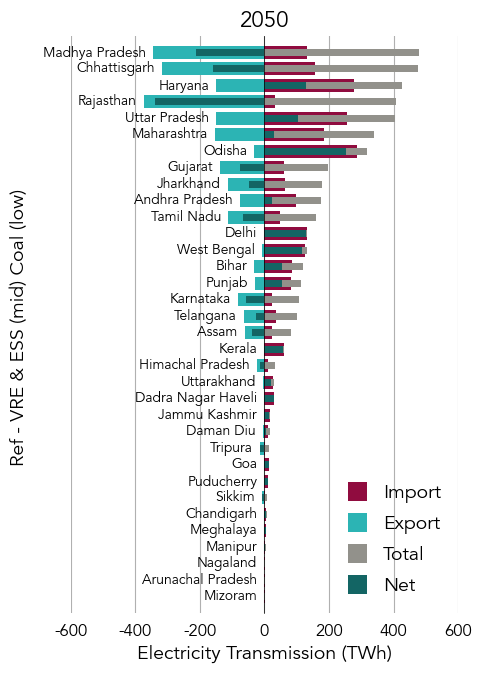

In [354]:


#scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid'
period = 2050

scen  = tech_cost_.loc[tech_cost_['label'].str.contains('Ref'), 'scenario'].to_numpy()[0]
label = tech_cost_.loc[tech_cost_['label'].str.contains('Ref'), 'label'].to_numpy()[0]
    
fig = plt.figure(figsize = (5, 7.5))
_ax = plt.subplot(111)

_plot_transmission_exchange_by_zone(_ax, transmission_, scen_labels_, scen, period, 
                                    title  = f'{period}',
                                    ylabel = f'{label}', 
                                    xlabel = 'Electricity Transfers (TWh)',
                                    N_states = 34)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

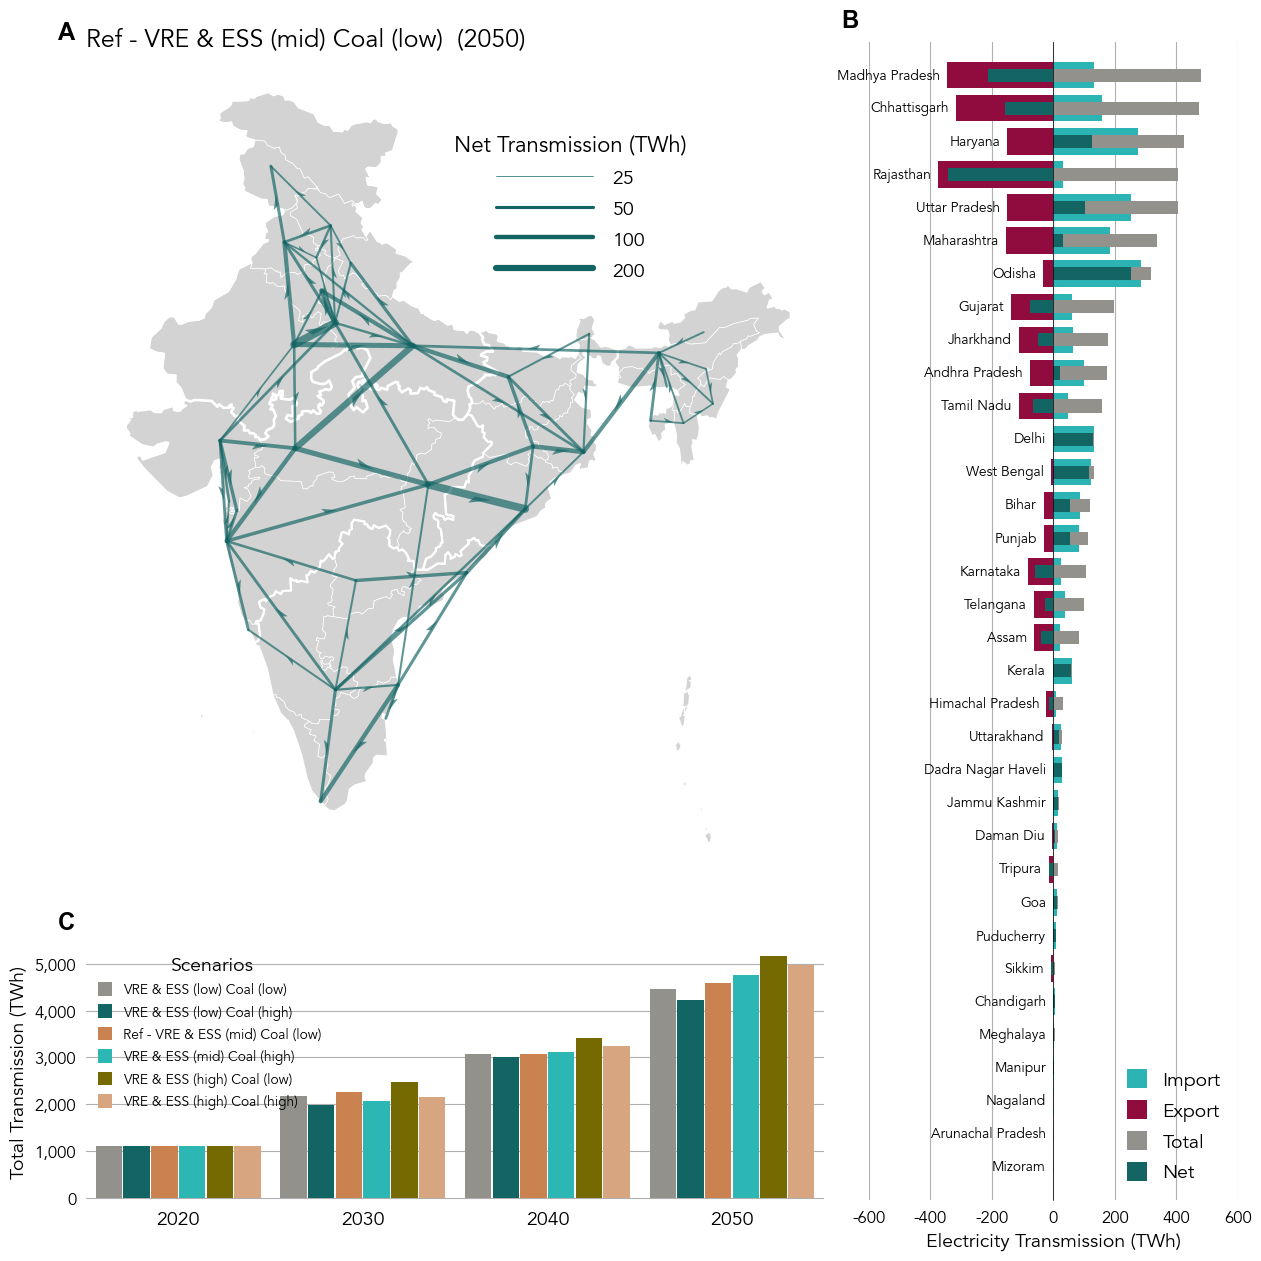

In [329]:

period = 2050

scen  = tech_cost_.loc[tech_cost_['label'].str.contains('Ref'), 'scenario'].to_numpy()[0]
ylabel = tech_cost_.loc[tech_cost_['label'].str.contains('Ref'), 'label'].to_numpy()[0]


fig, _ax = plt.subplot_mosaic([['A', 'B'],
                               ['A', 'B'],
                               ['A', 'B'],
                               ['C', 'B']], layout      = 'constrained', 
                                            figsize     = (12.5, 12.5), 
                                            gridspec_kw = {'width_ratios': [2, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')
    
_plot_transmission_exchange(_ax['A'], net_exchange_, load_zones_p_, period, scen)

_ax['A'].set_title(f'{ylabel} ({period})', fontsize = 18, loc = 'left')
    
# _plot_total_tranmission_exchange(_ax['C'], transmission_, tech_cost_, ylabel = 'Total Transmission (TWh)')

_plot_transmission_exchange_by_zone(_ax['B'], transmission_, tech_cost_, scen, period, 
                                    xlabel = 'Electricity Transfers (TWh)',
                                    N_states = 34)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Mosaic

In [353]:
transmission_ = _load_transmission(scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
['VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid']
[2020 2030 2040 2050]


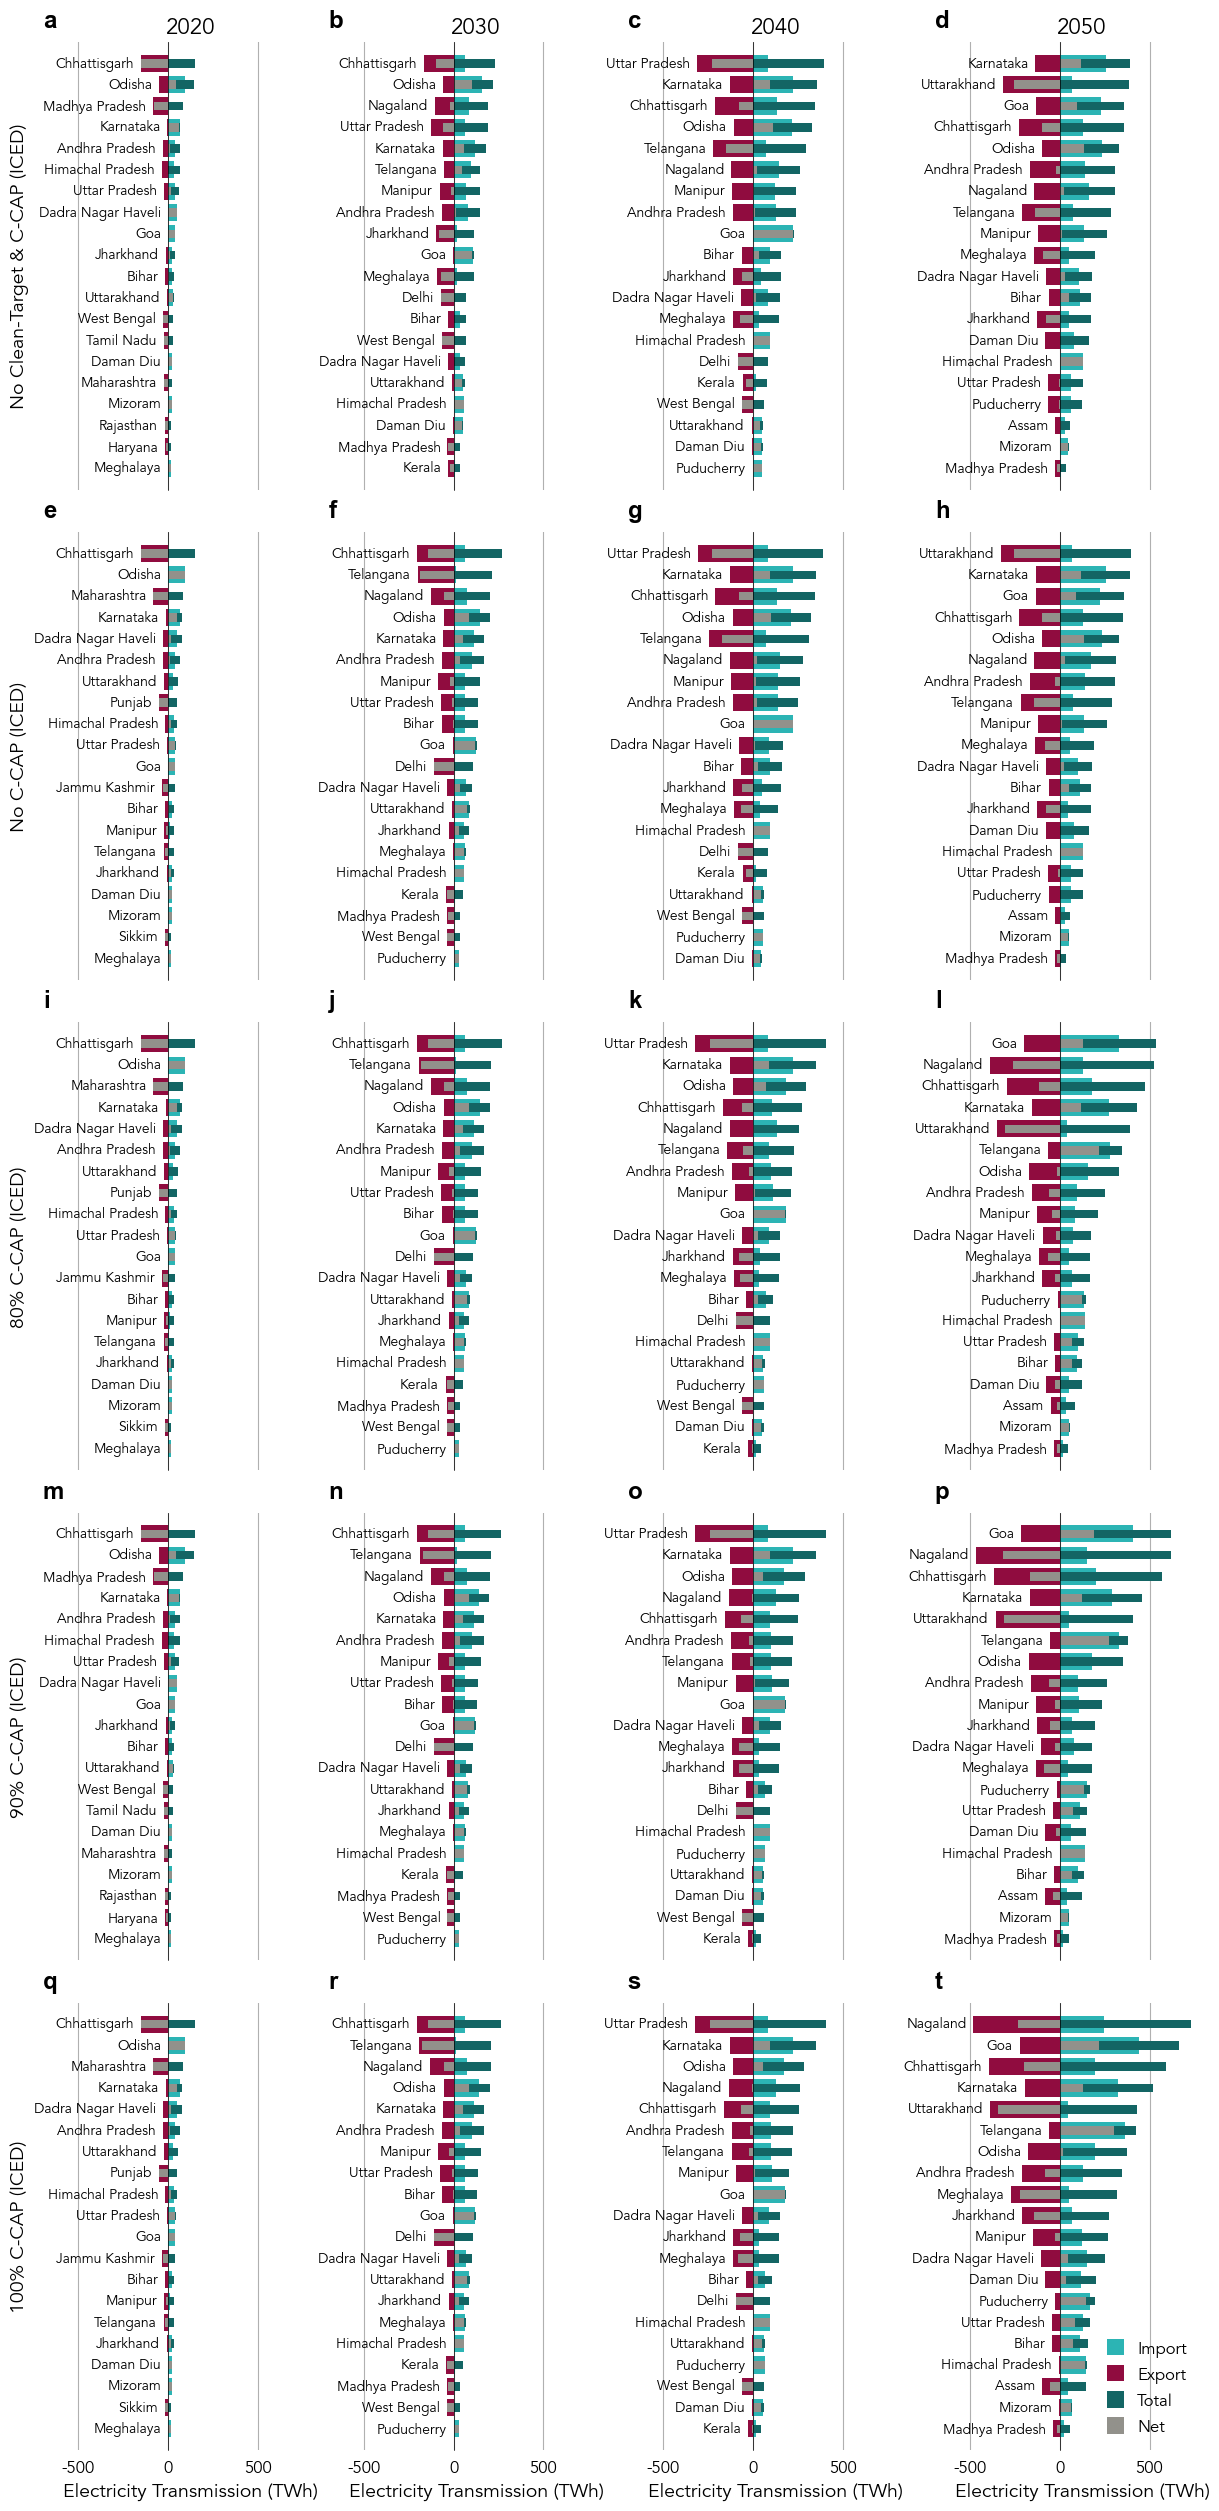

In [362]:
scens_   = transmission_['scenario'].unique()
periods_ = transmission_['period'].unique()
letters_ = [list(string.ascii_lowercase)[i*len(periods_):i*len(periods_) + len(periods_)] 
            for i in range(len(scens_))]

fig, _ax = plt.subplot_mosaic(letters_, layout      = 'constrained', 
                                        sharey      = True,
                                        sharex      = True,
                                        figsize     = (.75*len(letters_[0])*len(periods_), 5*len(letters_)), 
                                        gridspec_kw = {'width_ratios': [1]*len(letters_[0])})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

    
    
n      = len(letters_)*len(letters_[0])
k      = 1
legend = False

for i in range(len(letters_)):
    for j in range(len(letters_[i])):
        
        scen   = scens_[i]
        period = int(periods_[j])
        label  = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        if i == 0:
            title = f'{period}'
        else:
            title = ''
        
        if j == 0: 
            ylabel = label
        else: 
            ylabel = ''
            
        if i == len(letters_) - 1: 
            xlabel = 'Electricity Transmission (TWh)'
        else: 
            xlabel = ''
                    
        if k == n: 
            legend = True
        else:
            k += 1
            
        _plot_transmission_exchange_by_zone(_ax[letters_[i][j]], transmission_.copy(), 
                                            scen_labels_, scen, period, 
                                            title    = title, 
                                            ylabel   = ylabel, 
                                            xlabel   = xlabel,
                                            legend   = legend, 
                                            N_states = 20)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()